#### Importing libraries

In [4]:
import numpy as np 
import pandas as pd

In [5]:
df = pd.read_csv('benz_data.csv')
print(df.shape)
print(df.info())
df.head()

(4209, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      4209 non-null   int64  
 1   y       4209 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 65.9 KB
None


,ID,y
0,1,81.76701
1,2,93.42265
2,3,81.92086
3,4,79.08047
4,5,101.40711


#### Preprocessing

In [6]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(3367, 2)
(842, 2)


In [7]:
X_train_cat = train_set.select_dtypes(include='object').copy()
X_train_num = train_set.select_dtypes(include='int64').copy()
X_train_num.drop('ID', axis=1, inplace=True)

X_valid_cat = valid_set.select_dtypes(include='object').copy()
X_valid_num = valid_set.select_dtypes(include='int64').copy()
X_valid_num.drop('ID', axis=1, inplace=True)

y_train = train_set['y'].values
y_valid = valid_set['y'].values

In [8]:
import tensorflow as tf

class OneHotEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, num_oov_buckets=1,  **kwargs):
        super().__init__()
        self.vocab = vocab
        self.num_oov_buckets = num_oov_buckets
        
    def adapt(self, data):
        indices = tf.range(len(self.vocab), dtype=tf.int64)
        table_init = tf.lookup.KeyValueTensorInitializer(self.vocab, indices)
        self.table = tf.lookup.StaticVocabularyTable(table_init, self.num_oov_buckets)
        
    def call(self, inputs):
        cat_indices = self.table.lookup(inputs)
        one_hot =  tf.one_hot(cat_indices, depth=len(self.vocab)+self.num_oov_buckets)
        return tf.squeeze(one_hot, axis=1)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "vocab":self.vocab, "num_oov_buckets":self.num_oov_buckets}

#### keras Functional API

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [ ]:
# categorical features one hot encoding
one_hot_encoders = [OneHotEncodingLayer(vocab=np.unique(data.values).tolist()) for col, data in X_train_cat.iteritems()]

for encoder, (col, data) in zip(one_hot_encoders, X_train_cat.iteritems()):
    encoder.adapt(data.values)
    
cat_inputs = [tf.keras.Input(shape=(1,), dtype=tf.string) for _ in X_train_cat.iteritems()]
encoder_outs = [encoder(cat_input) for encoder, cat_input in zip(one_hot_encoders, cat_inputs)]

# concatenate categorical features
concat = tf.keras.layers.concatenate(encoder_outs, axis=-1)

# numerical features are binary
num_inputs = tf.keras.Input(shape=(X_train_num.shape[1]),)

# concatenate all features
concat_all = tf.keras.layers.concatenate([concat, num_inputs], axis=-1)

# build DNN
dense1 = tf.keras.layers.Dense(300, activation='relu')(concat_all)
dense2 = tf.keras.layers.Dense(200, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(100, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1)(dense3)

model = tf.keras.models.Model(inputs=[cat_inputs, num_inputs], outputs=outputs)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


train_cat_in = [data.values for col, data in X_train_cat.iteritems()]
valid_cat_in = [data.values for col, data in X_valid_cat.iteritems()]

expon_lr =  ExponentialLearningRate(factor=1.005)

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])

model.fit([train_cat_in, X_train_num.values], y_train, epochs=10, validation_data=((valid_cat_in, X_valid_num.values), y_valid), callbacks=[expon_lr])

2021-10-30 05:54:42.991495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
106/106 [==============================] - 2s 10ms/step - loss: 87.8695 - mae: 88.3695 - val_loss: 27.5114 - val_mae: 28.0111
Epoch 2/10
106/106 [==============================] - 1s 7ms/step - loss: 9.9769 - mae: 10.4629 - val_loss: 6.2893 - val_mae: 6.7710
Epoch 3/10
106/106 [==============================] - 1s 7ms/step - loss: 5.4872 - mae: 5.9644 - val_loss: 5.0958 - val_mae: 5.5791
Epoch 4/10
106/106 [==============================] - 1s 7ms/step - loss: 4.9235 - mae: 5.3960 - val_loss: 5.1720 - val_mae: 5.6417
Epoch 5/10
106/106 [==============================] - 1s 6ms/step - loss: 4.9090 - mae: 5.3821 - val_loss: 5.0350 - val_mae: 5.5102
Epoch 6/10
106/106 [==============================] - 1s 6ms/step - loss: 5.3964 - mae: 5.8743 - val_loss: 6.1308 - val_mae: 6.6191
Epoch 7/10
106/106 [==============================] - 1s 6ms/step - loss: 5.7761 - mae: 6.2555 - val_loss: 5.2250 - val_mae: 5.6957
Epoch 8/10
106/106 [==============================] - 1s 7ms/step - lo

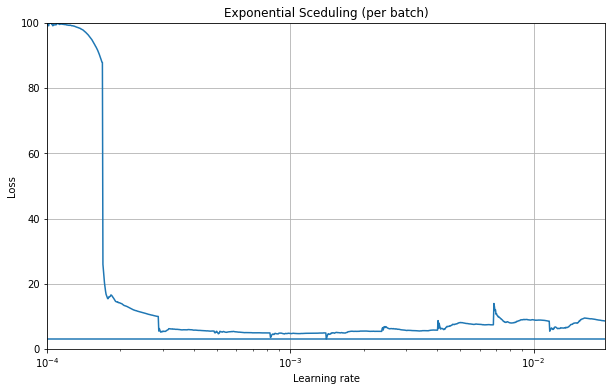

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.title('Exponential Sceduling (per batch)')
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae'])

model.fit([train_cat_in, X_train_num.values], y_train, epochs=100, 
          validation_data=((valid_cat_in, X_valid_num.values), y_valid), callbacks=[early_stopping_cb])

Epoch 1/100
106/106 [==============================] - 2s 10ms/step - loss: 4.8811 - mae: 5.3558 - val_loss: 4.8701 - val_mae: 5.3440
Epoch 2/100
106/106 [==============================] - 1s 6ms/step - loss: 4.4818 - mae: 4.9513 - val_loss: 4.7687 - val_mae: 5.2465
Epoch 3/100
106/106 [==============================] - 1s 6ms/step - loss: 4.4240 - mae: 4.8948 - val_loss: 4.7421 - val_mae: 5.2204
Epoch 4/100
106/106 [==============================] - 1s 6ms/step - loss: 4.4572 - mae: 4.9263 - val_loss: 4.8162 - val_mae: 5.2846
Epoch 5/100
106/106 [==============================] - 1s 9ms/step - loss: 4.3025 - mae: 4.7711 - val_loss: 4.7061 - val_mae: 5.1763
Epoch 6/100
106/106 [==============================] - 1s 7ms/step - loss: 4.3019 - mae: 4.7683 - val_loss: 5.1779 - val_mae: 5.6582
Epoch 7/100
106/106 [==============================] - 1s 6ms/step - loss: 4.2228 - mae: 4.6904 - val_loss: 4.8012 - val_mae: 5.2772
Epoch 8/100
106/106 [==============================] - 1s 6ms/step -

In [ ]:
model.evaluate((valid_cat_in, X_valid_num.values), y_valid)

27/27 [==============================] - 0s 3ms/step - loss: 5.3668 - mae: 5.8351


[5.3668060302734375, 5.835101127624512]

#### Making Predictions

In [ ]:
test = pd.read_csv("/kaggle/input/mercedes-benz-greener-manufacturing/test.csv.zip", compression='zip')
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
X_test_cat = test.select_dtypes(include='object').copy()
X_test_num = test.select_dtypes(include='int64').copy()
X_test_num.drop('ID', axis=1, inplace=True)

test_cat_in = [data.values for col, data in X_test_cat.iteritems()]

test['y'] = model.predict((test_cat_in, X_test_num.values))
test['y'].values

array([ 81.76701,  93.42265,  81.92086, ...,  87.70076, 103.37574,
        86.17945], dtype=float32)

In [ ]:
submission = test[['ID', 'y']]
submission.head()

,ID,y
0,1,81.767014
1,2,93.422653
2,3,81.920860
3,4,79.080467
4,5,101.407112
